In this notebook, we revisit the text classification example, but will work with an attention layer.

In [17]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Attention, Input, Flatten, Lambda, dot, Activation, concatenate
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import minmax_scale
import numpy as np
from PIL import Image
from skimage import io
from IPython.core.display import HTML

These steps are the same as before:

In [18]:
max_features   = 20000
maxlen         = 80
embedding_size = 128
num_lstm_units = 256

In [19]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test),  'test sequences')

25000 train sequences
25000 test sequences


In [20]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = sequence.pad_sequences(X_test,  maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:',  X_test.shape)

X_train shape: (25000, 80)
X_test shape: (25000, 80)


Keras has a built in [attention layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention), but is not easily usable on top of an LSTM. Instead, we utilize a custom layer inspired by [https://github.com/philipperemy/keras-attention-mechanism](https://github.com/philipperemy/keras-attention-mechanism). The illustration at [https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3](https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3) can help to understand this setup.

In [21]:
def attention_3d_block(hidden_states):
  # Shape of hidden_states is (batch_size, seqlen, LSTM size)
  hidden_size       = int(hidden_states.shape[2]) # LSTM size
  
  # Create a dense layer for the attention score and fetch out the last hidden state
  score_first_part  = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
  h_t               = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
  # score_first_part shape: (batch_size, seqlen, LSTM size)
  # h_t shape: (batch_size, LSTM size)
  
  # Take the dot product of both, to get the final attention scores and push them through a softmax layer
  score             = dot([score_first_part, h_t], [2, 1], name='attention_score')
  attention_weights = Activation('softmax', name='attention_weight')(score)
  # score shape: (batch_size, seqlen)
  # attention_weights shape: (batch_size, seqlen)
  
  # Take a dot product again to create a context vector
  context_vector    = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
  # context_vector shape: (batch_size, LSTM)
  
  # Add this context vector to h_t
  pre_activation    = concatenate([context_vector, h_t], name='attention_output')
  # pre_activation shape: (batch_size, LSTM*2)
  
  # And create a final dense layer
  attention_vector  = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
  # attention_vector shape: (batch_size, 128)

  return attention_vector

We then use this to define our network:

In [22]:
input_seq = Input(shape=(maxlen))
input_emb = Embedding(max_features, embedding_size)(input_seq)

# Important: since we need to hidden states in our attention layer, we set return_sequences=True
# return_sequences return the hidden state output for each input step
# return_state returns the hidden state output and cell state for the last input step

lstm = LSTM(num_lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_emb)
attention = attention_3d_block(lstm)

# We force all weights here to be positive to make visualization of the attention layer easier
dense = Dense(1, activation='sigmoid', use_bias=False, kernel_constraint=NonNeg())(Flatten()(attention))

model = Model(inputs=input_seq, outputs=dense)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 128)      2560000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 80, 256)      394240      embedding_1[0][0]                
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 80, 256)      65536       lstm_1[0][0]                     
____________________________________________________________________________________________

Keras also allows to visualize the model graph, which makes this model easier to understand:

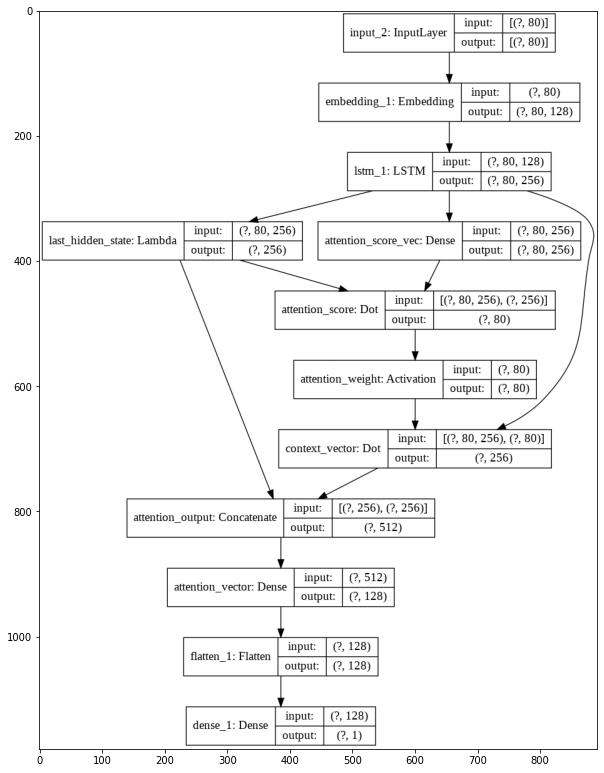

In [24]:
plot_model(model, to_file='model.png', show_shapes=True)
plt.subplots(figsize=(10, 20))
plt.imshow(Image.fromarray(io.imread('model.png')))

We can now train our network:

In [25]:
model.fit(X_train, y_train, batch_size=128, epochs=2, validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Test score:',    score)
print('Test accuracy:', acc)

Epoch 1/2
196/196 [==============================] - 99s 507ms/step - loss: 0.4459 - accuracy: 0.7824 - val_loss: 0.3518 - val_accuracy: 0.8450
Epoch 2/2
196/196 [==============================] - 5s 28ms/step - loss: 0.3762 - accuracy: 0.8362
Test score: 0.3761821985244751
Test accuracy: 0.8361600041389465


Recall that our model without attention gave: `Test accuracy: 0.8273199796676636`, so this is an improvement.

An added benefit is that we can now visualize the attention layer as follows.

In [56]:
test_instance_idx = 7

review     = ' '.join([[k for k,v in imdb.get_word_index().items() if v == w][0] for w in X_test[test_instance_idx] if w > 0])
prediction = model.predict(np.expand_dims(X_test[test_instance_idx], axis=0))[0][0]

print(review)
print('Predicted', prediction, '-- true label was:', y_test[test_instance_idx])

i of male their it of time buy treatment for it short in classic to pay is their may comedic make is getting using more he either watched yourself g an br really he judge do 7 to commercial annie make out so told rest you damsel there movies plot jack this having sidekick to childhood any this so family stopped stunning make his makes your not make present in at damsel to explanation one bit get still been as
Predicted 0.0034791266 -- true label was: 0


In [57]:
get_attention_weights = K.function(inputs=input_seq, outputs=model.get_layer(name='attention_weight').output)

# Apply a minmax as this makes visualization easier to see using the color map below
attention = np.expand_dims(
    minmax_scale(np.abs(get_attention_weights(
        np.expand_dims(X_test[test_instance_idx], axis=0)
    ))[0]
), axis=0)

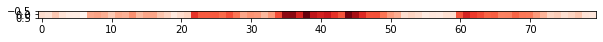

In [58]:
cmap = cm.get_cmap('Reds')

plt.figure(figsize=(10,10))
plt.imshow(attention, cmap=cmap)

In [59]:
text = ''
for i, w in enumerate(X_test[test_instance_idx]):
  word = [k for k,v in imdb.get_word_index().items() if v == w][0] if w != 0 else '-----'
  text += '<span style="background-color: {}">{}</span> '.format(rgb2hex(cmap(attention[0, i])[:3]), word)

HTML(text)